In [1]:
import os
import numpy as np
from tqdm import tqdm 
import pandas as pd
import matplotlib.backends.backend_pdf as backend_pdf
import matplotlib.pyplot as plt
import arviz
import seaborn as sns
import matplotlib
from ete3 import Tree
import argparse
from scipy.stats import mode
import arviz as az

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
#dataset =['20870959685460283'] #'11290418890035105'
datapath = '../_sim-30-leaves/simdata'#'BM-root-simple/ov=0.001_alpha=0.02/simdata'  
folder_runs = '../_sim-30-leaves/runs_v2' #'BM-root-simple/ov=0.001_alpha=0.02/runs_mean_rb=5
folder_simdata = datapath #'BM-root-simple/no_noise/simdata/'+d+'/' #'BM9/simdata/3513656273068705/' #args.folder_simdata +'/'
burnin=1500
MCMC_iter = 4000
dataset = os.listdir(folder_runs)
dataset = [d for d in dataset if d!='figures']
#dataset.remove('.DS_Store')
dataset


['78241558624040307', '68019208123646822', '15287225176595236']

In [5]:
all_pars = []
all_roots = []
all_vcv=[]
all_noisy_leaves = []
all_no_noise_leaves = []
for data in dataset: 
    
    # read parameters 
    sigma = np.genfromtxt(datapath+f'/{data}/gtheta_sim.csv', delimiter=',') 
    alpha = np.genfromtxt(datapath+f'/{data}/kalpha_sim.csv', delimiter=',') 
    true_pars = [alpha, sigma]
    all_pars.append(true_pars)

    # read root 
    root = np.genfromtxt(datapath+f'/{data}/root.csv', delimiter=',') 
    all_roots.append(root)
    vcv = np.genfromtxt(datapath+f'/{data}/phylogeny_vcv.csv', delimiter=' ')
    all_vcv.append(vcv)

    # read  leaves
    noisy_leaves = np.genfromtxt(datapath+f'/{data}/leaves.csv', delimiter=',') 
    all_noisy_leaves.append(noisy_leaves)
    no_noise_leaves = np.genfromtxt(datapath+f'/{data}/leaves_no_noise.csv', delimiter=',') 
    all_no_noise_leaves.append(no_noise_leaves)


In [6]:
def plot_leaves(leaves, root, true_pars, nrows=1, ncols=5, figsize=(25,5), leaves_no_noise=None): #figsize=(45,35)good for 30 leaves, nrows=6, ncols=5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True, sharey=True)
    for i, ax in zip(range(leaves.shape[0]), axes.flat):
        ax.plot(leaves[i][::2], leaves[i][1::2], '--o', color='orange', label='leaf', lw=2)
        ax.plot(root[::2], root[1::2], '--.', color='black', label='true root')
        if leaves_no_noise.any(): 
            ax.plot(leaves_no_noise[i][::2], leaves_no_noise[i][1::2], '--o', color='steelblue', label='leaf', lw=1)
    fig.suptitle(f'Simulated data: alpha={np.round(true_pars[0],3)}, sigma={np.round(true_pars[1],3)}')
    return(ax)

In [7]:
def plot_leaves_superimposed(leaves, root, true_pars, nrows=1, ncols=4, figsize=(25,5)):
    for j in range(leaves.shape[0]): # plot all leaves on top of each other 
        plt.plot(leaves[j][::2], leaves[j][1::2], '--.', color='orange', label='leaf', lw=1)
    plt.plot(root[::2], root[1::2], '--.', color='black', label='true root', lw=4)
    plt.suptitle(f'Simulated data: alpha={np.round(true_pars[0],3)}, sigma={np.round(true_pars[1],3)}')
    plt.show()

# Look at simulated data

In [8]:
#for i in range(len(dataset)):
#    ax=plot_leaves(all_no_noise_leaves[i],all_roots[i], all_pars[i], leaves_no_noise=all_no_noise_leaves[i])


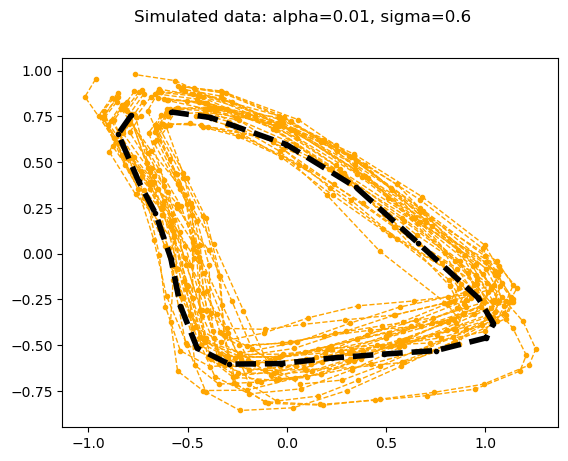

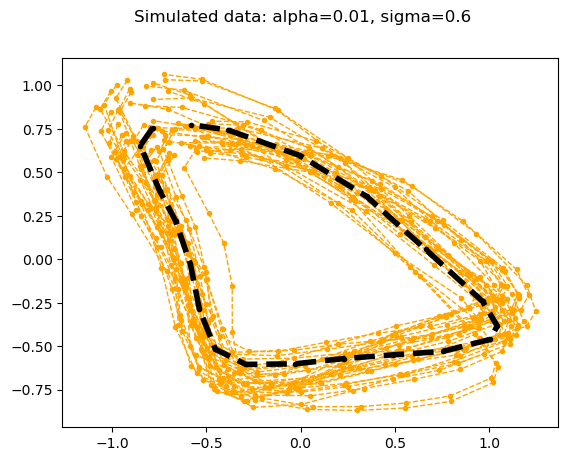

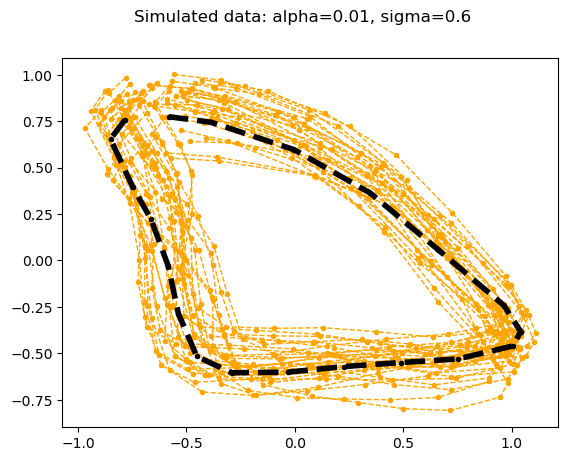

In [9]:
for i in range(len(dataset)):
    plot_leaves_superimposed(all_noisy_leaves[i],all_roots[i], all_pars[i])

# Compare different types of root estimates

### get mean and phylomean root estimates

In [10]:
def get_phylomean(leaves, vcv):
    phylomean = 1/(np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@np.ones(leaves.shape[0]))*np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@leaves
    return(phylomean)

In [11]:
# get mean and phylomean root estimates 
all_means = [np.mean(all_noisy_leaves[i], axis=0) for i in range(len(dataset))]
all_phylomeans = [get_phylomean(all_noisy_leaves[i], all_vcv[i]) for i in range(len(dataset))] # update this for more dynamic code
#mean_leaves = np.mean(leaves, axis=0)
#phylomean = 1/(np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@np.ones(leaves.shape[0]))*np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@leaves # update this for more dynamic code

### Get posterior root estimates

In [12]:
def get_mode(all_chains): 
    mode_est = []
    for i in range(all_chains.shape[1]):
        kdes = az.kde(all_chains[:,i].flatten(), bw='silverman')
        mest = kdes[0][np.where(kdes[1] == max(kdes[1]))[0][0]]
        mode_est.append(mest)
    mode_est = np.array(mode_est)
    return(mode_est)

In [13]:
all_trees_flat = []
all_true_roots = []

for data in dataset: 
    cur_folder_runs = folder_runs + f'/{data}/'    
    nthin = 1 # see from script/running conditions, not used for plotting
    pars_name = ['kalpha', 'gtheta']
    rep_path = len(pars_name)+1
    chains = os.listdir(cur_folder_runs) # use all chains in data seed folder 
    chains = [c for c in chains if c[0] not in ['_', '.']] # remove files starting with underscore
    print(chains)


    # In[6]:
    outputfolder = cur_folder_runs
    levelorder_tree = Tree('../levelorder_chazot_full_tree.nw')#Tree('chazot_subtree_levelorder.nw') #Tree('chazot_full_tree_levelorder.nw')
    temp_name = ['' for i in range(len(chains))]#['runs_'+chains[i]+'_' for i in range(len(chains))] #[outputfolder+chains[i]+'/' for i in range(len(chains))] # #['runs_'+chains[i]+'_' for i in range(len(chains))] #['runs_'+chains[i]+'_' for i in range(len(chains))] #
    path = outputfolder+'_*'+'-'.join(chains)
    if not os.path.isdir(path): 
        os.mkdir(path)

    # In[7]:


    leafidx = []
    for leaf in levelorder_tree:
        leafidx.append(leaf.name)
    print(leafidx)

    # get innernode idx 
    # small tree = 9, large tree = 59
    nnodes = 59 #args.nnodes #59
    leafidxint = [int(leafidx[i]) for i in range(len(leafidx))]
    nodes = list(range(nnodes))
    inneridx = set(nodes)-set(leafidxint)
    inneridx

    # # Plot paths all nodes 
    nxd = 40
    raw_trees = [np.genfromtxt(cur_folder_runs + chains[i]+'/'+temp_name[i]+"tree_nodes.csv", delimiter = ",") for i in range(len(chains))]
    tree_counters = [np.genfromtxt(cur_folder_runs + chains[i]+'/'+temp_name[i]+"tree_counter.csv", delimiter = ",").astype(int) for i in range(len(chains))]
    flat_trees_raw = [raw_trees[i].reshape(len(tree_counters[i]),nnodes,nxd) for i in range(len(raw_trees))]
    flat_true_tree = np.genfromtxt(folder_simdata+f"/{data}/flat_true_tree.csv", delimiter = ",")
    flat_trees = np.array([np.repeat(flat_trees_raw[i], tree_counters[i], axis=0)[burnin*rep_path:(MCMC_iter//nthin)*rep_path] for i in range(len(flat_trees_raw))])
    all_trees_flat.append(flat_trees)
    all_true_roots.append(flat_true_tree[0])

['magic-leaf-531', 'young-sky-529', 'expert-shadow-529']
['3', '4', '11', '17', '18', '19', '20', '27', '28', '29', '39', '40', '9', '31', '41', '42', '33', '43', '44', '35', '45', '46', '47', '51', '52', '53', '54', '55', '57', '58']
['bright-durian-528', 'cerulean-paper-526', 'hopeful-sky-527']
['3', '4', '11', '17', '18', '19', '20', '27', '28', '29', '39', '40', '9', '31', '41', '42', '33', '43', '44', '35', '45', '46', '47', '51', '52', '53', '54', '55', '57', '58']
['robust-bird-524', 'proud-wave-523', 'rare-bird-525']
['3', '4', '11', '17', '18', '19', '20', '27', '28', '29', '39', '40', '9', '31', '41', '42', '33', '43', '44', '35', '45', '46', '47', '51', '52', '53', '54', '55', '57', '58']


In [14]:
# get posterior mean and posterior median 
all_roots = [all_trees_flat[i][:,:,0,:].reshape(-1,40) for i in range(len(all_trees_flat))] # get all roots, across chains for all data sets 
all_median_root = [np.median(all_roots[i], axis=0) for i in range(len(all_roots))]
all_mean_root = [np.mean(all_roots[i], axis=0) for i in range(len(all_roots))]
all_mode_root = [get_mode(all_roots[i]) for i in range(len(all_roots))]

In [17]:
all_median_root

[array([-0.73172098,  0.82319748, -0.79501826,  0.72576901, -0.67096388,
         0.47810784, -0.57430795,  0.2977351 , -0.48781203,  0.0197468 ,
        -0.43878478, -0.28072165, -0.36442065, -0.541439  , -0.21445838,
        -0.64168504,  0.0266564 , -0.63909274,  0.26956013, -0.59495914,
         0.52274144, -0.54628825,  0.78417945, -0.49333429,  1.04089558,
        -0.39898615,  1.07824707, -0.31617597,  1.00213951, -0.17358943,
         0.69153154,  0.12293651,  0.37288612,  0.43151256,  0.03425621,
         0.66394222, -0.33004937,  0.81034827, -0.52555338,  0.84041589]),
 array([-0.85979632,  0.7908622 , -0.92094311,  0.68030614, -0.80879754,
         0.39827257, -0.71442837,  0.19618614, -0.6237959 , -0.09495235,
        -0.5674293 , -0.38166359, -0.47591358, -0.62086508, -0.30823344,
        -0.71193603, -0.03520875, -0.69856775,  0.24211083, -0.63317519,
         0.51927483, -0.56095219,  0.79250956, -0.49622306,  1.04872656,
        -0.39964357,  1.08191532, -0.3166433 ,  0

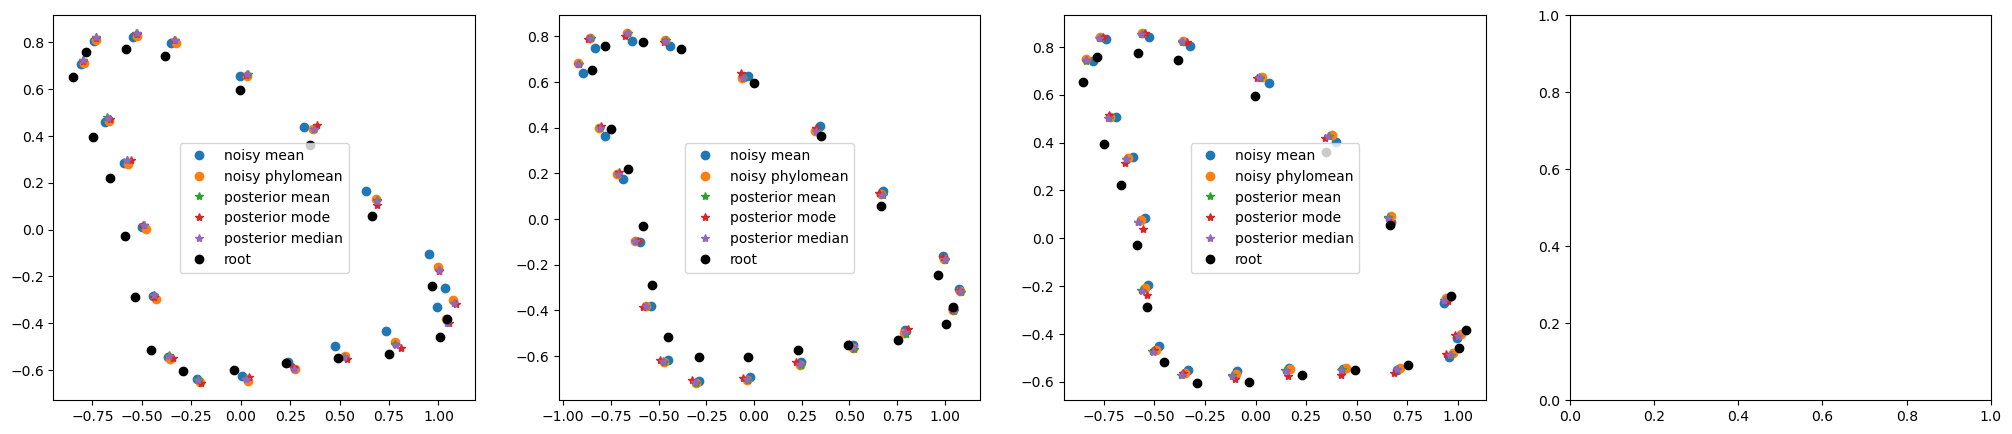

In [18]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(25,5))
for i, ax in zip(range(len(dataset)), axes.flat):
    ax.plot(all_means[i][0::2],all_means[i][1::2], 'o', label='noisy mean')
    ax.plot(all_phylomeans[i][0::2],all_phylomeans[i][1::2], 'o', label='noisy phylomean')
    ax.plot(all_mean_root[i][::2], all_mean_root[i][1::2], '*', label='posterior mean')
    ax.plot(all_mode_root[i][::2], all_mode_root[i][1::2], '*', label='posterior mode')
    ax.plot(all_median_root[i][::2], all_median_root[i][1::2], '*', label='posterior median')
    ax.plot(all_true_roots[i][::2], all_true_roots[i][1::2], 'o', label='root', color='black')
    ax.legend()

# MSE for different root estimates

In [16]:
MSE_mean = []
MSE_phylomean = []
MSE_posterior_mean = []
MSE_posterior_mode = []
MSE_posterior_median = []
for i in range(len(dataset)):
    MSE_mean.append(np.mean((all_means[i]-all_true_roots[i])**2))
    MSE_phylomean.append(np.mean((all_phylomeans[i]-all_true_roots[i])**2))
    MSE_posterior_mean.append(np.mean((all_mean_root[i]-all_true_roots[i])**2))
    MSE_posterior_median.append(np.mean((all_median_root[i]-all_true_roots[i])**2))
    MSE_posterior_mode.append(np.mean((all_mode_root[i]-all_true_roots[i])**2))


In [26]:
print(dataset)
print(MSE_mean)
print(MSE_phylomean)
print(MSE_posterior_mean)
print(MSE_posterior_median)
print(MSE_posterior_mode)

['78241558624040307', '68019208123646822', '15287225176595236']
[0.003891335854439823, 0.002433650226529677, 0.0034139539541404446]
[0.0036230895683023305, 0.0030886887486464075, 0.0029220532727343256]
[0.004716983208881642, 0.0028692794974988283, 0.0021033402399577407]
[0.0041926298965570315, 0.002972082268301023, 0.002250322893400078]
[0.0037697150910379965, 0.0034154338158150247, 0.0025223739099951995]


In [27]:
all_MSE = np.array([MSE_mean, MSE_phylomean, MSE_posterior_mean, MSE_posterior_median, MSE_posterior_mode])
np.mean(all_MSE, axis=1)

array([0.00324631, 0.00321128, 0.00322987, 0.00313835, 0.00323584])